# Лабораторна робота №5
### Передавальне навчання (transfer learning) для задачі класифікації зображень

### Мета: набути навички використання та донавчання (fine-tuning) наперед навчених моделей для розв’язання задачі класифікації зображень.

# Імпорт бібліотек та завантаження датасету
Використовується датасет Hot Dog - Not Hot Dog

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -o ./drive/MyDrive/DeepL/archive.zip -d ./dataset

Archive:  ./drive/MyDrive/DeepL/archive.zip
  inflating: ./dataset/seefood/test/hot_dog/133012.jpg  
  inflating: ./dataset/seefood/test/hot_dog/133015.jpg  
  inflating: ./dataset/seefood/test/hot_dog/133245.jpg  
  inflating: ./dataset/seefood/test/hot_dog/135628.jpg  
  inflating: ./dataset/seefood/test/hot_dog/138933.jpg  
  inflating: ./dataset/seefood/test/hot_dog/138937.jpg  
  inflating: ./dataset/seefood/test/hot_dog/138969.jpg  
  inflating: ./dataset/seefood/test/hot_dog/139177.jpg  
  inflating: ./dataset/seefood/test/hot_dog/142835.jpg  
  inflating: ./dataset/seefood/test/hot_dog/143012.jpg  
  inflating: ./dataset/seefood/test/hot_dog/144956.jpg  
  inflating: ./dataset/seefood/test/hot_dog/146227.jpg  
  inflating: ./dataset/seefood/test/hot_dog/146834.jpg  
  inflating: ./dataset/seefood/test/hot_dog/147874.jpg  
  inflating: ./dataset/seefood/test/hot_dog/152106.jpg  
  inflating: ./dataset/seefood/test/hot_dog/154409.jpg  
  inflating: ./dataset/seefood/test/hot_dog/

In [4]:
dir_train='dataset/train'
dir_test='dataset/test'

df_train = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train,
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    validation_split=0.2,
    subset="training",
)

df_valid = tf.keras.preprocessing.image_dataset_from_directory(
    dir_test,
    batch_size=32,
    image_size=(256, 256),
    seed=123,
    validation_split=0.2,
    subset="validation",
)


Found 498 files belonging to 2 classes.
Using 399 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


In [5]:
df_train.class_names

['hot_dog', 'not_hot_dog']

# Розробка та тренування моделей
## 1. Власна модель з попередніх лабораторних

In [6]:
class ConvBlock(tf.keras.Model):
  def __init__ (
      self,
      filters: int,
      kernel_size: int,
      activation: str = "relu",
      name: str | None=None
  ):
    super().__init__(name=name)

    self.Conv1 = layers.Conv2D(
      filters = filters,
      #activation = activation,
      kernel_size = kernel_size,
      padding='same'
    )

    self.batchnorm1 = layers.BatchNormalization()
    self.activation1 = layers.Activation('relu')

    self.Conv2 = layers.Conv2D(
      filters = filters,
      kernel_size = kernel_size,
      padding='same'
    )

    self.batchnorm2 = layers.BatchNormalization()
    self.activation2 = layers.Activation('relu')

    self.Conv3 = layers.Conv2D(
      filters = filters,
      kernel_size = kernel_size,
      activation = activation,
      padding='same'
    )

    self.MaxPool = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')

  def call(self, inputs, training: bool):
    x = self.Conv1(inputs)
    x = self.batchnorm1(x)
    x = self.activation1(x)
    x = self.Conv2(x)
    x = self.batchnorm2(x)
    x = self.activation2(x)
    x = self.Conv3(x)
    return self.MaxPool(x)

In [7]:
class ClassificationHead(tf.keras.Model):
    def __init__(self, hidden_dim: list[int], n_classes: int, *args, **kwargs):
        super(ClassificationHead, self).__init__(*args, **kwargs)

        self.dense1 = layers.Dense(units=hidden_dim[0], activation='relu')
        self.dropout1 = layers.Dropout(rate = 0.2)
        self.dense2 = layers.Dense(units=hidden_dim[1], activation='relu')
        #self.dropout2 = layers.Dropout(rate = 0.1)
        self.dense3 = layers.Dense(units=hidden_dim[2], activation='relu')
        self.out = layers.Dense(n_classes, activation='softmax')

    def call(self, inputs, training: bool):
        x = self.dense1(inputs)
        x = self.dropout1(x)
        x = self.dense2(x)
        #x = self.dropout2(x)
        x = self.dense3(x)
        return self.out(x)

In [8]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, n_classes: int, name: str | None = None):
        super().__init__(name=name)

        self.data_aug = tf.keras.Sequential([
          layers.RandomFlip("horizontal_and_vertical"),
          layers.RandomRotation(0.2),
          layers.RandomZoom((0.1, 0.2))
          ])

        self.Conv1 = ConvBlock(filters=64, kernel_size=3)
        self.Conv2 = ConvBlock(filters=64, kernel_size=3)
        self.Conv3 = ConvBlock(filters=64, kernel_size=3)

        self.flatten = layers.GlobalAveragePooling2D()
        self.classification = ClassificationHead(hidden_dim=[128, 128, 32], n_classes=n_classes, name="head")

    def call(self, inputs, training: bool):
        x = self.data_aug(inputs)
        x = self.Conv1(x)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.flatten(x)
        return self.classification(x)

## 2. Наперед навчена модель ResNet з моєю класифікаційною частиною
З замороженими ваговими параметрами

In [9]:
#Combining feature extractor with my classification head
#I used the same head as before
class ResNetClassifier(tf.keras.Model):
  def __init__(self, n_classes: int, name: str | None = None):
      super().__init__(name=name)

      self.feature_extractor = tf.keras.applications.ResNet50V2(
          include_top=False,
          weights='imagenet',
          input_shape=(256, 256, 3)
      )

      self.feature_extractor.trainable = False #freezing the weights parameters of ResNet model
      self.flatten = layers.GlobalAveragePooling2D()
      self.classification = ClassificationHead(hidden_dim=[128, 64, 32], n_classes=n_classes, name="head")

  def call(self, inputs, training: bool):
      x = self.feature_extractor(inputs)
      x = self.flatten(x)
      return self.classification(x)

## 3. Модель ResNet з моєю класифікаційною частиною
З НЕ замороженими ваговими параметрами

In [10]:
class ResNetClassifier_2(tf.keras.Model):
  def __init__(self, n_classes: int, name: str | None = None):
      super().__init__(name=name)

      self.feature_extractor = tf.keras.applications.ResNet50V2(
          include_top=False,
          weights='imagenet',
          input_shape=(256, 256, 3)
      )

      self.feature_extractor.trainable = True
      self.flatten = layers.GlobalAveragePooling2D()
      self.classification = ClassificationHead(hidden_dim=[128, 64, 32], n_classes=n_classes, name="head")

  def call(self, inputs, training: bool):
      x = self.feature_extractor(inputs)
      x = self.flatten(x)
      return self.classification(x)

#Функції для виведення графіків

In [11]:
y_true = []
x_test = []

for images, labels in df_valid:
    y_true.extend(labels.numpy())
    x_test.extend(images.numpy())

x_test = np.concatenate(x_test, axis=0)

#Криві навчання
def plot_learning_curve(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(history.history['accuracy'], color='#b8113d')
    axs[0].plot(history.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(history.history['loss'], color='#b8113d')
    axs[1].plot(history.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

#Confusion matrix
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=['Not hot dog', 'Hot dog'], yticklabels=['Not hot dog', 'Hot dog'])
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

# Тренування моделей

In [12]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience = 3, min_lr=0.000001)]

## 1. Власна модель

In [13]:
my_model = CNNClassifier(n_classes = 2)
my_model.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

my_model.build((None, 256, 256, 3))
my_model.summary()

Model: "cnn_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv_block (ConvBlock)      multiple                  76160     
                                                                 
 conv_block_1 (ConvBlock)    multiple                  111296    
                                                                 
 conv_block_2 (ConvBlock)    multiple                  111296    
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                         
                                                                 
 head (ClassificationHead)   multiple                  29026     
                                                    

In [14]:
history_my = my_model.fit(
    df_train,
    epochs = 60,
    batch_size = 128,
    callbacks = callback, #Early stopping ON
    validation_data = df_valid
)

Epoch 1/60
13/13 [==============================] - 67s 3s/step - loss: 0.6828 - accuracy: 0.5363 - val_loss: 0.6936 - val_accuracy: 0.5200 - lr: 3.0000e-04
Epoch 2/60
13/13 [==============================] - 19s 1s/step - loss: 0.6409 - accuracy: 0.6241 - val_loss: 0.6943 - val_accuracy: 0.4600 - lr: 3.0000e-04
Epoch 3/60
13/13 [==============================] - 19s 1s/step - loss: 0.6362 - accuracy: 0.6516 - val_loss: 0.7016 - val_accuracy: 0.5200 - lr: 3.0000e-04
Epoch 4/60
13/13 [==============================] - 20s 1s/step - loss: 0.6336 - accuracy: 0.6416 - val_loss: 0.6994 - val_accuracy: 0.4900 - lr: 3.0000e-04
Epoch 5/60
13/13 [==============================] - 19s 1s/step - loss: 0.6001 - accuracy: 0.6942 - val_loss: 0.6961 - val_accuracy: 0.5100 - lr: 3.0000e-05
Epoch 6/60
13/13 [==============================] - 19s 1s/step - loss: 0.5986 - accuracy: 0.6992 - val_loss: 0.6938 - val_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 7/60
13/13 [==============================] - 19s 1s

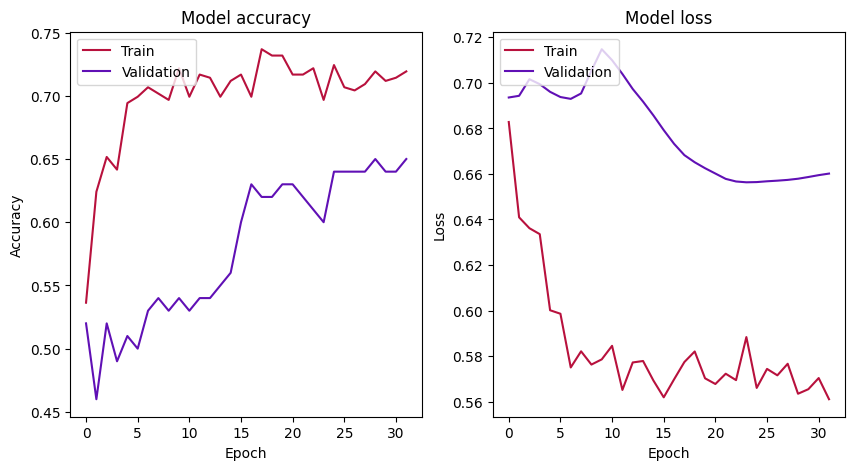

In [15]:
plot_learning_curve(history_my)

1/1 [==============================] - 0s 217ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61        48
           1       0.64      0.73      0.68        52

    accuracy                           0.65       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.65      0.65      0.65       100



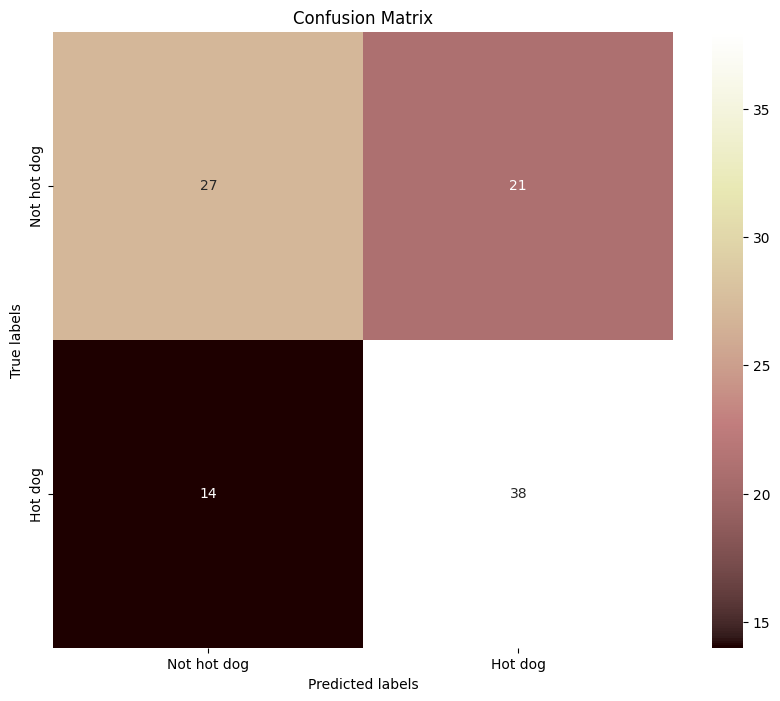

In [16]:
y_true = []
y_pred1_classes = []

for images, labels in df_valid:
    y_true.extend(labels.numpy())
    predictions = my_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred1_classes.extend(predicted_classes)

print("Classification Report:")
print(classification_report(y_true, y_pred1_classes))

plot_confusion_matrix(y_true, y_pred1_classes)

## 2. ResNet model

In [17]:
ResNet_model_freezed = ResNetClassifier(n_classes = 2)
ResNet_model_freezed.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay = 1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

ResNet_model_freezed.build((None, 256, 256, 3))

94668760/94668760 [==============================] - 0s 0us/step


In [18]:
hist_freeze = ResNet_model_freezed.fit(
    df_train,
    epochs = 40,
    batch_size = 64,
    callbacks = callback, #Early stopping ON
    validation_data = df_valid
)

Epoch 1/40
13/13 [==============================] - 19s 846ms/step - loss: 7.3806 - accuracy: 0.4862 - val_loss: 3.8619 - val_accuracy: 0.5300 - lr: 3.0000e-04
Epoch 2/40
13/13 [==============================] - 3s 160ms/step - loss: 4.4218 - accuracy: 0.5188 - val_loss: 1.6825 - val_accuracy: 0.5300 - lr: 3.0000e-04
Epoch 3/40
13/13 [==============================] - 3s 156ms/step - loss: 3.3938 - accuracy: 0.5138 - val_loss: 1.4971 - val_accuracy: 0.5100 - lr: 3.0000e-04
Epoch 4/40
13/13 [==============================] - 3s 156ms/step - loss: 2.2432 - accuracy: 0.5489 - val_loss: 1.4785 - val_accuracy: 0.4800 - lr: 3.0000e-04
Epoch 5/40
13/13 [==============================] - 2s 155ms/step - loss: 1.9490 - accuracy: 0.5464 - val_loss: 1.1806 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/40
13/13 [==============================] - 2s 153ms/step - loss: 1.8897 - accuracy: 0.5489 - val_loss: 1.2076 - val_accuracy: 0.5500 - lr: 3.0000e-04
Epoch 7/40
13/13 [===========================

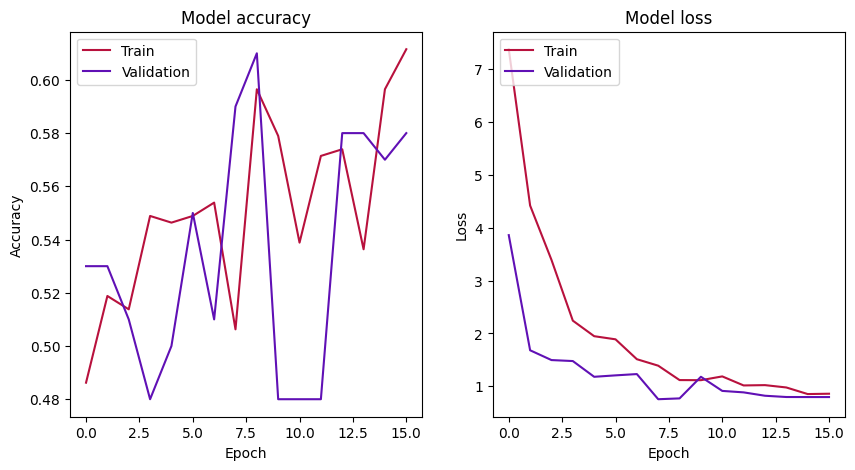

In [19]:
plot_learning_curve(hist_freeze)

1/1 [==============================] - 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55        48
           1       0.59      0.62      0.60        52

    accuracy                           0.58       100
   macro avg       0.58      0.58      0.58       100
weighted avg       0.58      0.58      0.58       100



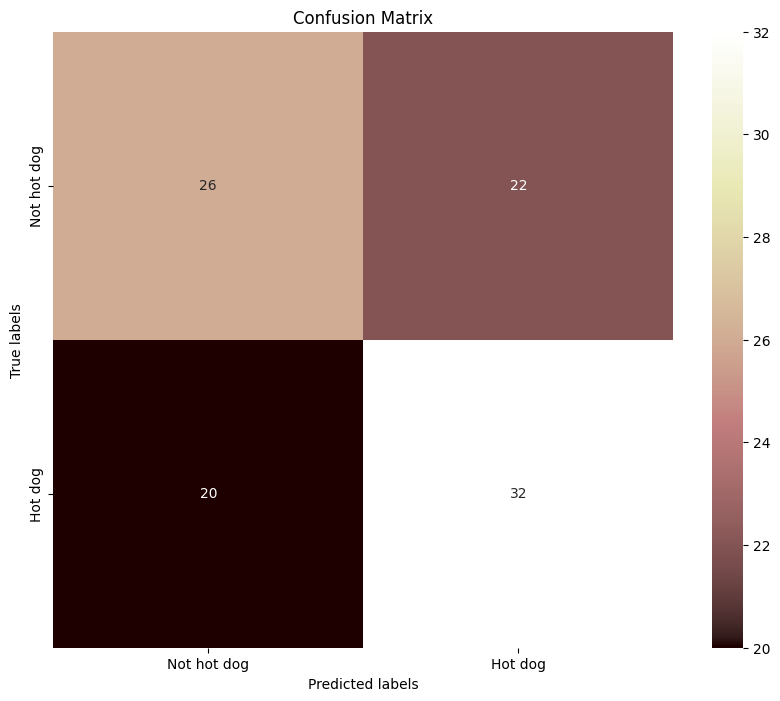

In [20]:
y_true = []
y_pred2_classes = []

for images, labels in df_valid:
    y_true.extend(labels.numpy())
    predictions = ResNet_model_freezed.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred2_classes.extend(predicted_classes)

print("Classification Report:")
print(classification_report(y_true, y_pred2_classes))

plot_confusion_matrix(y_true, y_pred2_classes)

## 3. ResNet model (no freezing)

In [21]:
ResNet_model_unfreezed = ResNetClassifier_2(n_classes = 2)
ResNet_model_unfreezed.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay = 1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
hist_unfreeze = ResNet_model_unfreezed.fit(
    df_train,
    epochs = 30,
    batch_size = 64,
    callbacks = callback, #Early stopping ON
    validation_data = df_valid
)

Epoch 1/30
13/13 [==============================] - 51s 859ms/step - loss: 0.6203 - accuracy: 0.6316 - val_loss: 0.6770 - val_accuracy: 0.5300 - lr: 1.0000e-04
Epoch 2/30
13/13 [==============================] - 6s 416ms/step - loss: 0.2458 - accuracy: 0.9674 - val_loss: 0.4902 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 3/30
13/13 [==============================] - 6s 391ms/step - loss: 0.0920 - accuracy: 0.9900 - val_loss: 0.3390 - val_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 4/30
13/13 [==============================] - 6s 390ms/step - loss: 0.0294 - accuracy: 0.9975 - val_loss: 0.3990 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 5/30
13/13 [==============================] - 6s 460ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.3922 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 6/30
13/13 [==============================] - 6s 391ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.3340 - val_accuracy: 0.8800 - lr: 1.0000e-04
Epoch 7/30
13/13 [===========================

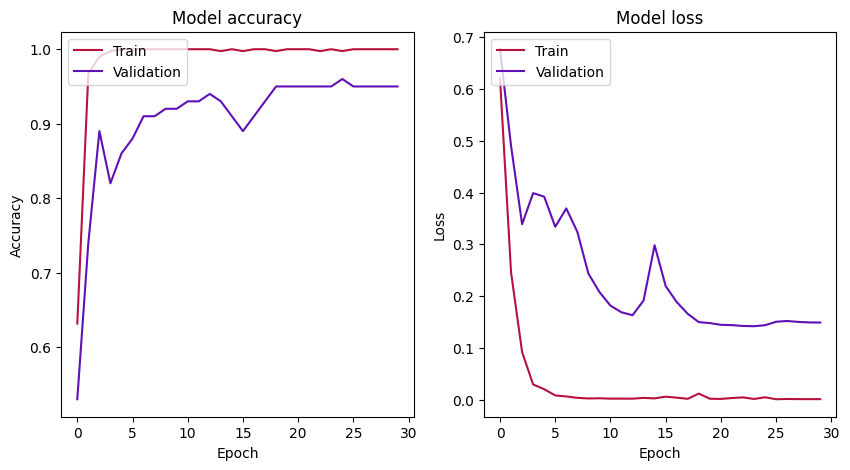

In [23]:
plot_learning_curve(hist_unfreeze)

1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 1s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        48
           1       0.91      1.00      0.95        52

    accuracy                           0.95       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



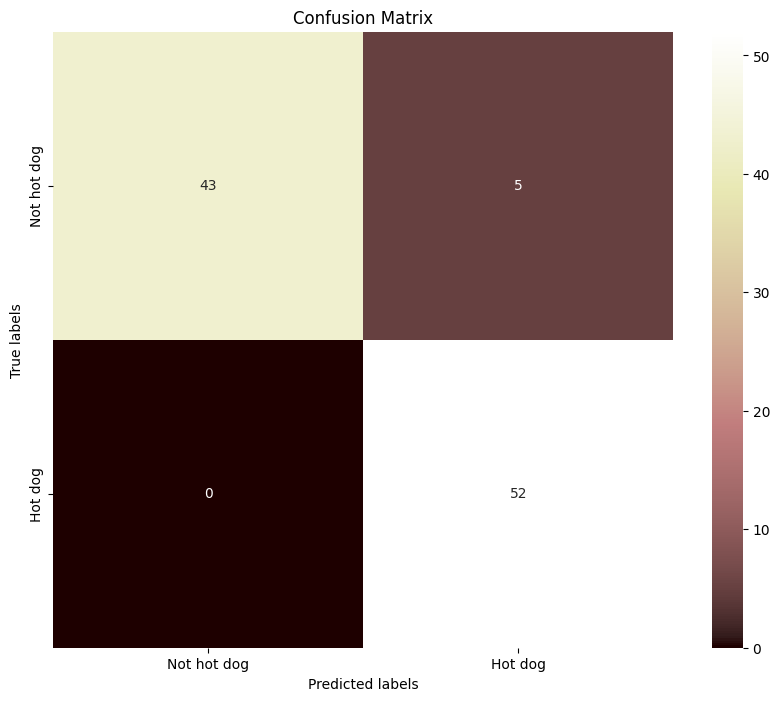

In [24]:
y_true = []
y_pred3_classes = []

for images, labels in df_valid:
    y_true.extend(labels.numpy())
    predictions = ResNet_model_unfreezed.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred3_classes.extend(predicted_classes)

print("Classification Report:")
print(classification_report(y_true, y_pred3_classes))

plot_confusion_matrix(y_true, y_pred3_classes)

# Analysis of results

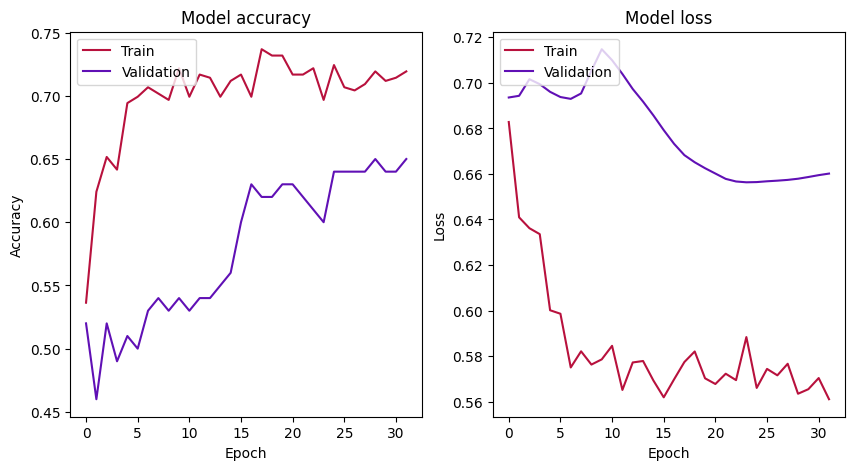

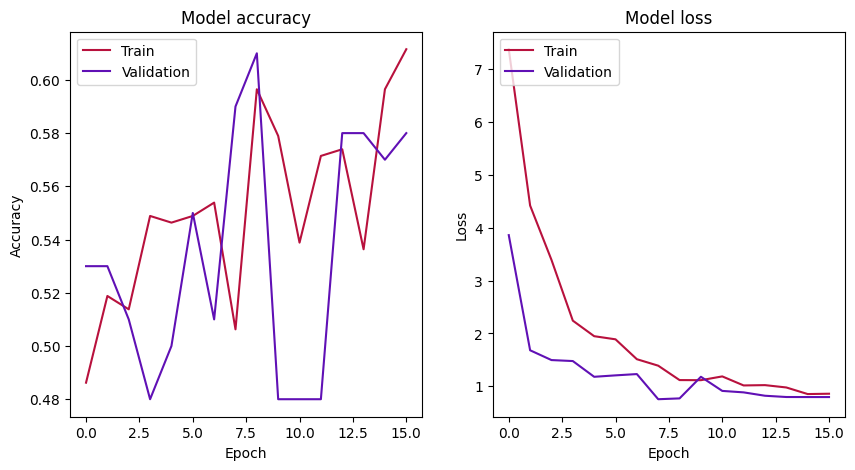

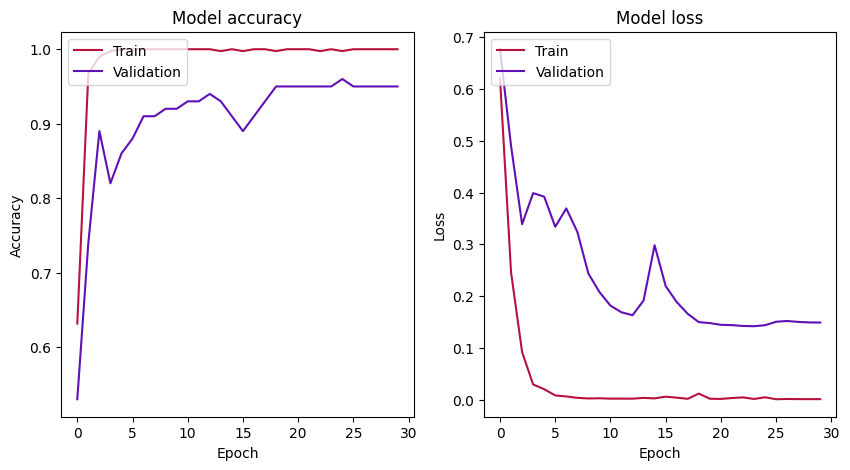

In [25]:
plot_learning_curve(history_my)
plot_learning_curve(hist_freeze)
plot_learning_curve(hist_unfreeze)

1/1 [==============================] - 0s 28ms/step


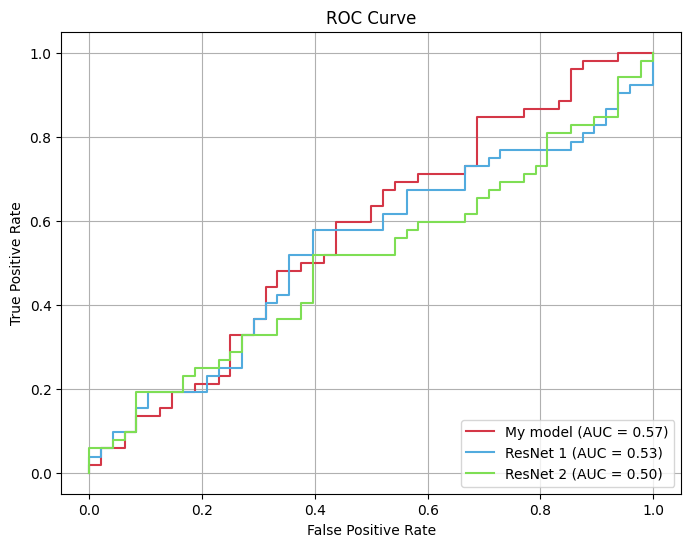

In [28]:
#y_true_np = np.array(y_true)
y_true_binary = y_true[:]
y_pred1 = []
y_pred2 = []
y_pred3 = []

for images, labels in df_valid:
    predictions1 = my_model.predict(images)
    predictions2 = ResNet_model_freezed.predict(images)
    predictions3 = ResNet_model_unfreezed.predict(images)
    y_pred1.extend(predictions1)
    y_pred2.extend(predictions2)
    y_pred3.extend(predictions3)

y_pred1 = np.array(y_pred1)
y_pred2 = np.array(y_pred2)
y_pred3 = np.array(y_pred3)

y_pred1_prob = y_pred1[:, 1]
y_pred2_prob = y_pred2[:, 1]
y_pred3_prob = y_pred3[:, 1]

fpr1, tpr1, _ = roc_curve(y_true_binary, y_pred1_prob)
auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_true_binary, y_pred2_prob)
auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_true_binary, y_pred3_prob)
auc3 = auc(fpr3, tpr3)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='#d43747', label=f'My model (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, color='#52abde', label=f'ResNet 1 (AUC = {auc2:.2f})')
plt.plot(fpr3, tpr3, color='#7ede54', label=f'ResNet 2 (AUC = {auc3:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.grid()
plt.show()